<a href="https://colab.research.google.com/github/iamBehzad/Advanced-Differential-Evolution/blob/main/ADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install deap


In [18]:
import numpy as np
np.random.seed(42)

def logistic_map(x, mu=4):
    return mu * x * (1 - x)

def chaotic_initialization(pop_size, dim, lb, ub):
    pop = []
    x = np.random.rand(dim)  # Initial value for logistic map
    for i in range(pop_size):
        x = logistic_map(x)  # Apply logistic map for chaotic initialization
        individual = {'Position': np.clip(x, lb, ub) , 'Cost': None}
        pop.append(individual)
    return pop

def ade(N, fobj, lb, ub, dim, MaxIt):
    # ADE Parameters
    nPop = N  # Population Size
    NPopmin = 4
    NPopinit = 28
    Pop1Size = NPopinit
    Pop2Size = nPop - Pop1Size

    beta_min = 0.2  # Lower Bound of Scaling Factor
    beta_max = 0.8  # Upper Bound of Scaling Factor
    pCR = 0.2  # Crossover Probability

    # Initialization
    #pop = [{'Position': np.random.uniform(lb, ub, dim), 'Cost': None} for _ in range(nPop)]
    pop = chaotic_initialization(nPop, dim, lb, ub)
    BestSol = {'Position': None, 'Cost': np.inf}

    for i in range(nPop):
        pop[i]['Position'] = np.clip(pop[i]['Position'], lb, ub)  # Initial bounds
        pop[i]['Cost'] = fobj(pop[i]['Position'])

    BestCost = np.zeros(MaxIt)

    # Find initial global best solution
    for ind in pop:
        if ind['Cost'] < BestSol['Cost']:
            BestSol = ind.copy()

    pop1 = pop[:Pop1Size]
    pop2 = pop[Pop1Size:]

    # ADE Main Loop
    for it in range(MaxIt):
        Pop1Size = round((((NPopmin - NPopinit) / MaxIt) * it) + NPopinit)

        if Pop1Size < len(pop1):
            Pop2Size = nPop - Pop1Size
            pop2.append(BestSol.copy())  # Add BestSol to pop2
            WorstSolPop1_index = np.argmax([p['Cost'] for p in pop1])
            pop1.pop(WorstSolPop1_index)

        # Phase 1: Update pop1
        for i in range(Pop1Size):
            x1 = pop1[i]['Position']
            A = np.random.permutation(Pop1Size)
            A = np.delete(A, np.where(A == i))
            a, b, c = A[:3]

            # Scale Factor (beta1)
            if np.linalg.norm(pop1[b]['Position'] - pop1[c]['Position']) > (np.linalg.norm(ub - lb) / 10):
                beta1 = np.random.uniform(beta_min, beta_max, dim)
            else:
                beta1 = np.random.uniform(beta_min, beta_max * (1 + np.random.rand()), dim)

            y1 = pop1[a]['Position'] + beta1 * (pop1[b]['Position'] - pop1[c]['Position'])
            y1 = np.clip(y1, lb, ub)
            z1 = crossover(x1, y1, pCR)

            # Evaluate and update best solution
            NewSol = {'Position': z1, 'Cost': fobj(z1)}
            if NewSol['Cost'] < pop1[i]['Cost']:
                pop1[i] = NewSol

            # Update global best solution
            if pop1[i]['Cost'] < BestSol['Cost']:
                BestSol = pop1[i].copy()

        # Phase 2: Update pop2
        if Pop2Size >= (2 * NPopmin):
            pop2[:NPopmin] = sorted(pop1, key=lambda p: p['Cost'])[:NPopmin]

        for j in range(Pop2Size):
            x2 = pop2[j]['Position']
            resOfTop2 = (np.random.rand(dim) * (x2 - pop2[0]['Position']) +
                         np.random.rand(dim) * (x2 - pop2[1]['Position']))
            beta2 = np.random.uniform(beta_min, beta_max, dim)
            y2 = beta2 * resOfTop2
            y2 = np.clip(y2, lb, ub)
            z2 = crossover(x2, y2, pCR)
            NewSol2 = {'Position': z2, 'Cost': fobj(z2)}

            if NewSol2['Cost'] < BestSol['Cost']:
                BestSol = NewSol2.copy()
            pop2.append(NewSol2)

        # Sort pop2 and retain only Pop2Size solutions
        pop2 = sorted(pop2, key=lambda p: p['Cost'])[:Pop2Size]

        # Update BestCost array
        BestCost[it] = BestSol['Cost']

    return BestCost, BestSol['Position']

def crossover(x, y, pCR):
    z = np.zeros_like(x)
    j0 = np.random.randint(0, len(x))
    for jj in range(len(x)):
        if jj == j0 or np.random.rand() <= pCR:
            z[jj] = y[jj]
        else:
            z[jj] = x[jj]
    return z

In [19]:
from scipy.optimize import differential_evolution, rosen
from deap import base, creator, tools, algorithms

# 2. Differential Evolution (DE) implementation using SciPy
def original_de(dim, lb, ub, max_iter, fobj):
    bounds = [(lb, ub)] * dim
    best_costs = []

    def callback(xk, convergence):
        best_costs.append(fobj(xk))

    result = differential_evolution(fobj, bounds, maxiter=max_iter, callback=callback)
    return best_costs, result.x

# 3. PSO implementation
class Particle:
    def __init__(self, dim, bounds):
        self.position = np.random.uniform(bounds[0], bounds[1], dim)
        self.velocity = np.random.uniform(-1, 1, dim)
        self.best_position = np.copy(self.position)
        self.best_cost = np.inf

def pso(dim, bounds, max_iter, swarm_size, fobj):
    swarm = [Particle(dim, bounds) for _ in range(swarm_size)]
    global_best_position = np.random.uniform(bounds[0], bounds[1], dim)
    global_best_cost = np.inf
    best_costs = []

    for _ in range(max_iter):
        for particle in swarm:
            cost = fobj(particle.position)
            if cost < particle.best_cost:
                particle.best_position = particle.position
                particle.best_cost = cost
            if cost < global_best_cost:
                global_best_position = particle.position
                global_best_cost = cost

        best_costs.append(global_best_cost)

        for particle in swarm:
            particle.velocity = (0.5 * particle.velocity +
                                 np.random.uniform(0, 1) * (particle.best_position - particle.position) +
                                 np.random.uniform(0, 1) * (global_best_position - particle.position))
            particle.position = np.clip(particle.position + particle.velocity, bounds[0], bounds[1])

    return best_costs, global_best_position

# 4. Genetic Algorithm (GA) implementation using DEAP
def ga(dim, lb, ub, max_iter, pop_size, fobj):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, lb, ub)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, dim)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (fobj(ind),))
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=pop_size)
    best_costs = []

    for gen in range(max_iter):
        algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, verbose=False)
        best_ind = tools.selBest(population, 1)[0]
        best_costs.append(best_ind.fitness.values[0])

    return best_costs, best_ind

# Objective function examples
def sphere(x):
    return np.sum(x ** 2)

def rosenbrock(x):
    return rosen(x)

def rastrigin_f(x):
    A = 10
    return A * len(x) + np.sum(x ** 2 - A * np.cos(2 * np.pi * x))


Testing on Sphere Function

 ADE Results Sphere: [7.82043869e+00 6.83606904e+00 5.51923796e+00 2.64797737e+00
 2.05022573e+00 1.97157134e+00 1.19790887e+00 7.35010233e-01
 5.88907558e-01 5.78427644e-01 5.77845699e-01 1.66105806e-01
 4.84561511e-02 1.42128432e-02 5.32123651e-03 2.22805255e-03
 2.85285124e-04 2.85285124e-04 2.54878369e-04 2.45734581e-04
 7.43232930e-06 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06053484e-13 5.06053484e-13
 5.06053484e-13 5.06053484e-13 5.06

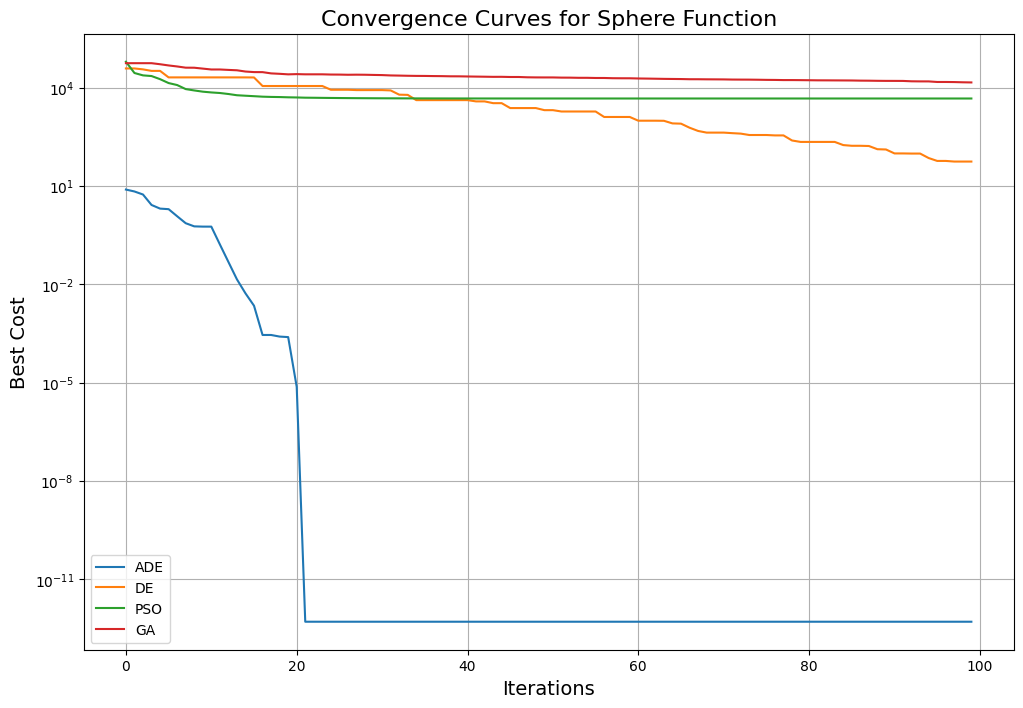


Testing on Rosenbrock Function

 ADE Results Rosenbrock: [431.43416621 431.43416621 410.06343995 408.9404306  408.9404306
 382.47884116 319.12257705 223.50583169 148.25617715 148.25617715
  99.29765809  62.81563877  62.81563877  56.32170462  38.27768073
  30.26371303  29.57828736  29.57828736  29.56831679  29.11177067
  29.11177067  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.97348036  28.97348036  28.97348036  28.97348036
  28.97348036  28.9

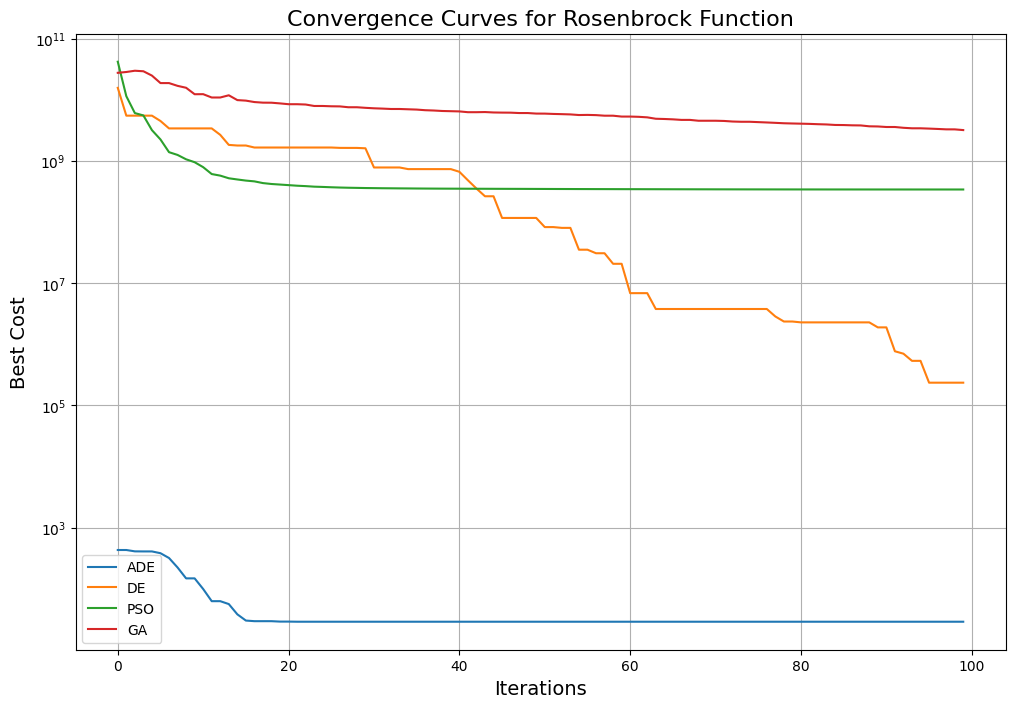


Testing on Rastrigin Function

 ADE Results Rastrigin: [1.36358179e+02 1.36358179e+02 1.04320827e+02 8.75755658e+01
 5.55463544e+01 5.28123636e+01 3.63195343e+01 2.88588630e+01
 1.34158492e+01 1.33290637e+01 7.98650080e+00 1.66114776e+00
 1.66114776e+00 8.32417244e-02 8.32417244e-02 6.38300641e-02
 4.78181858e-04 4.78181858e-04 3.45429297e-04 5.26624660e-07
 5.26624660e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+0

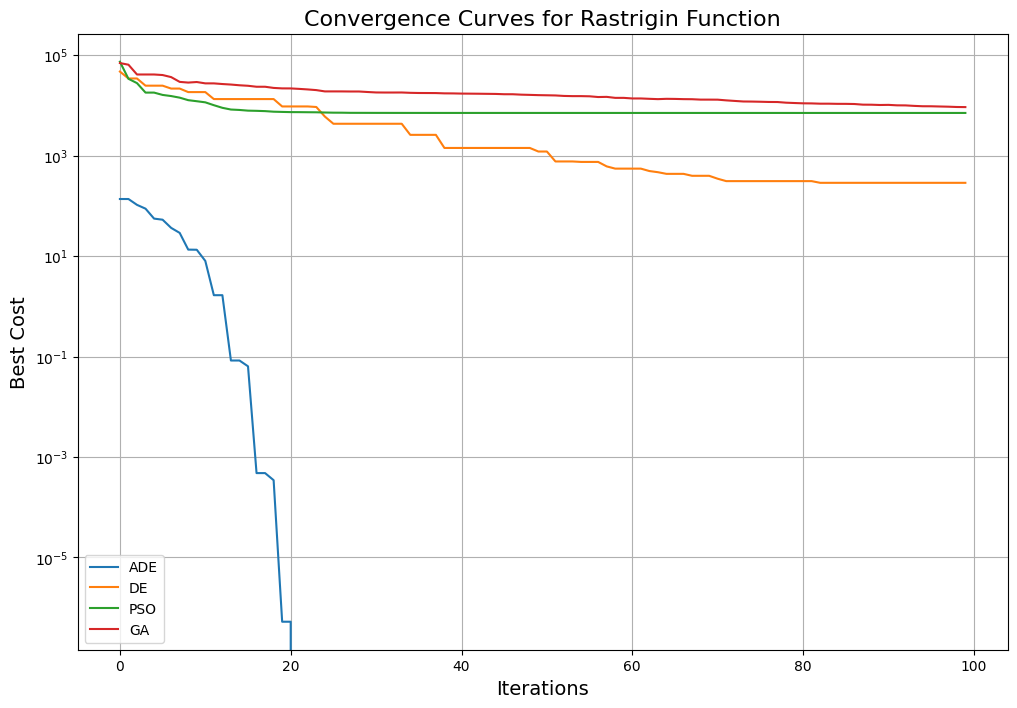

In [20]:
import matplotlib.pyplot as plt

# Run comparisons
dim = 30
lb, ub = -100, 100
max_iter = 100
pop_size = 30
swarm_size = pop_size

# Objective functions to test
objectives = {"Sphere": sphere, "Rosenbrock": rosenbrock, "Rastrigin": rastrigin_f}

# Dictionary to store results
results = {"ADE": [], "DE": [], "PSO": [], "GA": []}

for name, fobj in objectives.items():
    print(f"\nTesting on {name} Function")

    # Run ADE
    ade_costs, _ = ade(pop_size, fobj, lb, ub, dim, max_iter)
    results["ADE"].append(ade_costs)

    # Run DE
    de_costs, _ = original_de(dim, lb, ub, max_iter, fobj)
    results["DE"].append(de_costs)

    # Run PSO
    pso_costs, _ = pso(dim, (lb, ub), max_iter, swarm_size, fobj)
    results["PSO"].append(pso_costs)

    # Run GA
    ga_costs, _ = ga(dim, lb, ub, max_iter, pop_size, fobj)
    results["GA"].append(ga_costs)

    # Print results
    print(f"\n ADE Results {name}: {ade_costs}")
    print(f"\n DE Results {name}: {de_costs}")
    print(f"\n PSO Results {name}: {pso_costs}")
    print(f"\n GA Results {name}: {ga_costs}")

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.plot(ade_costs, label='ADE')
    plt.plot(de_costs, label='DE')
    plt.plot(pso_costs, label='PSO')
    plt.plot(ga_costs, label='GA')
    plt.title(f'Convergence Curves for {name} Function', fontsize=16)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Best Cost', fontsize=14)
    plt.yscale('log')  # Log scale for better visualization
    plt.grid(True)
    plt.legend()
    plt.show()

# Now, results contain all the convergence curves for each function tested
